In [1]:
import os
import os.path
#import tensorflow as tf
import numpy as np
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SimpleRNN
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.utils import plot_model
import random
from sklearn.preprocessing import StandardScaler
#import tensorflow as tf
#print(tf.__version__)

Using TensorFlow backend.


# read data as type in each fold

In [2]:
Time=4
Fs=750
dir_path =((r"I:\\Companys\\邢冀川\\光纤线号分析\\数据20190912"))#这里的路径是打包文件里数据中训练数据文件夹的路径#
filename = []
sigNames = []
sigfileCount = dict()
i=0
Na=0
pa=0
n_event_kinds=0
siglist = []
#get the signal types from directory
for parent, dirnames, filenames in os.walk(dir_path):  # 三个参数：分别返回1.父目录 2.所有文件夹名字（不含路径） 3.所有文件名字
    for dirname in dirnames:  # 输出文件夹信息
        #print("parent is:" + parent)
        #print("dirname is" + dirname)
        sigNames.append(dirname)
        sigfileCount[sigNames[n_event_kinds]] = 0
        n_event_kinds += 1
    for filename in filenames:  # 输出文件信息
        #print( "parent is:" + parent)
        if len(parent) <= len(dir_path):
            continue
        i = sigNames.index(parent[-2:])
        sigfileCount[sigNames[i]] += 1
        #print("filename is:" + filename)
        #print( "the full name of the file is:" + os.path.join(parent, filename)) # 输出文件路径信息
print(n_event_kinds)
        
i=0
j=0
Nf=np.zeros(10) #Nf=np.ones((1,100),dtype=int)
siglist = []
for sigtype in sigNames:
    ifr = np.random.rand
    typepath = os.path.join(dir_path, sigtype)
    files = int(sigfileCount[sigNames[i]])
    rfn = np.random.randint(0, files-1, size=(files-1))
    #print(rfn,sigfileCount[sigNames[i]])
    print(typepath)
    j = 0
    f = 0
    break_flag=False
    for parent, dirnames, filenames in os.walk(typepath):
        for filename in filenames:  # 输出文件夹信息
            if j in rfn:
                fullpath = os.path.join(typepath, filename)
                #print(fullpath)
                fr=open(fullpath,'rb')                                         
                fr.seek(0,2)
                pf=fr.tell()
                sigcount=int(pf/Time/Fs/4)
                Nf[i]+=sigcount
                print(Nf[i])
                fr.seek(0,0)
                signal=np.fromfile(fr,dtype=">f4",count=-1)
                sig=np.reshape(signal[:int(sigcount)*Time*Fs],(int(sigcount),Time*Fs)) 
                if f==0:
                    dlst=sig
                else:
                    clst=sig
                    dlst=np.r_[dlst,clst]
                fr.close()
                f += 1
                if Nf[i]>5000:
                    break_flag=True
                    break
            j += 1
            if break_flag==True:
                break;
        if break_flag==True:
            break;
    sigfileCount[sigNames[i]]=Nf[i]  # files count dict to signals count dict
    siglist.append(dlst)
    print (dlst.shape)
    print ("event types：%d"% (Nf[i]))
    Na += Nf[i]
    pa += pf;
    i += 1
print ("event start: %d" % (pa))
print ("all event phases：%d"% (Na))

print(sigNames)
print(siglist[0].shape)
lmax=np.max(Nf)
print('max num:',lmax)
Mf=Nf.copy()
Mf[Nf<1]=lmax
lmin=np.min(Mf) #get the least number
print('min num:',lmin)


7
I:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\人工
905.0
1814.0
2732.0
3713.0
4932.0
6151.0
(6151, 3000)
event types：6151
I:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\噪声
6315.0
(6315, 3000)
event types：6315
I:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\回填
2367.0
5360.0
(5360, 3000)
event types：5360
I:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\怠机
3075.0
6150.0
(6150, 3000)
event types：6150
I:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\挖掘
2747.0
5822.0
(5822, 3000)
event types：5822
I:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\电镐
1640.0
3280.0
4920.0
6560.0
(6560, 3000)
event types：6560
I:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\行驶
2757.0
5514.0
(5514, 3000)
event types：5514
event start: 252912000
all event phases：41872
['人工', '噪声', '回填', '怠机', '挖掘', '电镐', '行驶']
(6151, 3000)
max num: 6560.0
min num: 5360.0


In [4]:
print(siglist[0].shape)
vmax = np.max(siglist[0])
print(vmax)
vmin = np.min(siglist[0])
print(vmin)


(6151, 3000)
10745.6
3082.0


# show each signal data 

5969.0


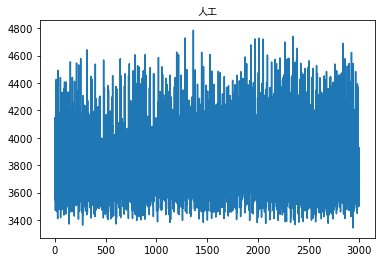

6315.0


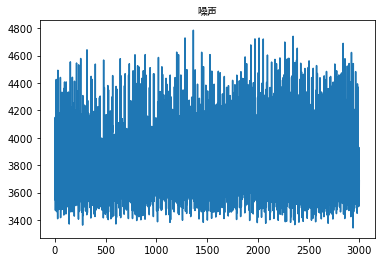

7727.0


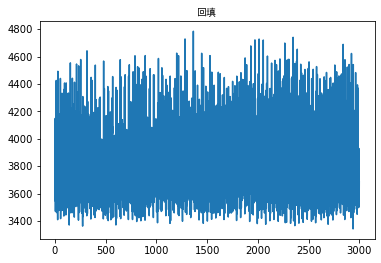

6150.0


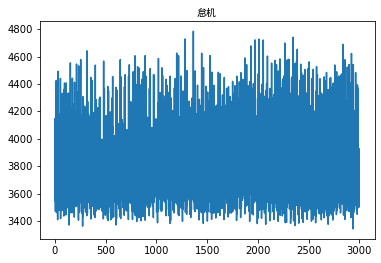

5822.0


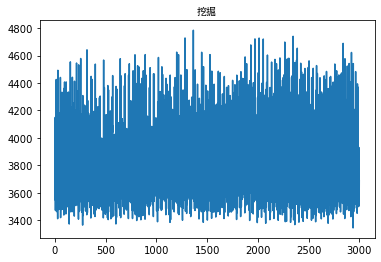

5222.0


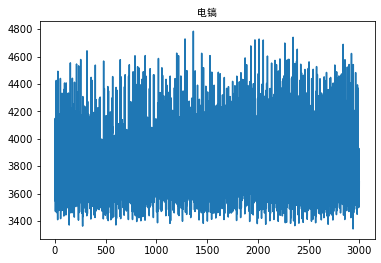

6990.0


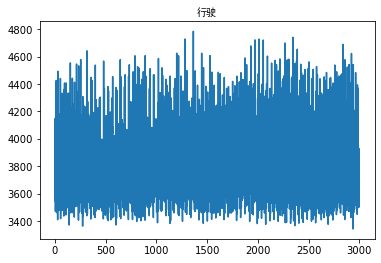

In [42]:
for i in range(0,n_event_kinds): # 行中
    print(Nf[i])
    for j in range(0,1):
        plt.clf() #清空画布上的所有内容
        plt.title(sigNames[i], fontproperties="SimHei") #     （黑体）
        plt.plot(sig[j+1,:])        
        plt.pause(0.01)
    plt.pause(1)

# reshape data into array and reshuffle at random order, normalize them, then split into trine and test subset

In [24]:
#数据标签
y_label=np.zeros((int(lmin*n_event_kinds),n_event_kinds),np.uint16)    
print(y_label.shape)
#one_hot_train_labels = to_categorical(train_labels)
for i in np.arange(n_event_kinds):
    if i==0:
        dlst=siglist[0][:int(lmin),:]
    else:
        clst=siglist[i][:int(lmin),:]
        dlst=np.r_[dlst,clst]
    y_label[int(i*lmin):int((i+1)*lmin), i:i+1] = 1
    print(y_label[int(i*lmin)])
allsig=dlst        
ttSamples = allsig.shape[0]
print('samples count:', ttSamples)

#shuffle data and labels
idxrand = np.arange(allsig.shape[0])
np.random.shuffle(idxrand)
data = allsig[idxrand]
labels = y_label[idxrand]

#plt.plot(sig[500,:])
normalized_data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
#plt.plot(normalized_data[500,:])
numTr = int(ttSamples*0.9)
train_data = normalized_data[0:numTr,:]
train_label = labels[0:numTr,:]
test_data = normalized_data[numTr:,:]
test_label = labels[numTr:,:]


(37520, 7)
[1 0 0 0 0 0 0]
[0 1 0 0 0 0 0]
[0 0 1 0 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 0 1 0 0]
[0 0 0 0 0 1 0]
[0 0 0 0 0 0 1]
samples count: 37520


# create a small neural network for recognition

In [28]:
train_data = np.expand_dims(train_data, axis=2) #表示是是增加的维度是在第三个维度上
test_data = np.expand_dims(test_data, axis=2) #表示是是增加的维度是在第三个维度上
#stack layers
max_features = Time * Fs
model = Sequential()
model.add(layers.Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.001), activation='relu',input_shape=(max_features,1)))
model.add(layers.MaxPooling1D(3))
#model.add(Dropout(0.5))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(n_event_kinds, activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
#plot_model(model, show_shapes=True, to_file='fiber_model5.png')



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 2996, 128)         768       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 998, 128)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 994, 64)           41024     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 331, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 331, 64)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 327, 32)           10272     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)               

# train and test model, save the trained model parameters to file for later recognition

Train on 23637 samples, validate on 10131 samples
Epoch 1/8
23637/23637 [==============================] - 6s 243us/step - loss: 0.9432 - accuracy: 0.6475 - val_loss: 0.6525 - val_accuracy: 0.8151
Epoch 2/8
23637/23637 [==============================] - 6s 235us/step - loss: 0.3262 - accuracy: 0.8944 - val_loss: 0.2860 - val_accuracy: 0.9651
Epoch 3/8
23637/23637 [==============================] - 6s 235us/step - loss: 0.1575 - accuracy: 0.9548 - val_loss: 0.1969 - val_accuracy: 0.9517
Epoch 4/8
23637/23637 [==============================] - 6s 236us/step - loss: 0.1006 - accuracy: 0.9721 - val_loss: 0.0989 - val_accuracy: 0.9904
Epoch 5/8
23637/23637 [==============================] - 6s 237us/step - loss: 0.0716 - accuracy: 0.9813 - val_loss: 0.0598 - val_accuracy: 0.9928
Epoch 6/8
23637/23637 [==============================] - 6s 244us/step - loss: 0.0549 - accuracy: 0.9873 - val_loss: 0.0444 - val_accuracy: 0.9980
Epoch 7/8
23637/23637 [==============================] - 6s 239us/st

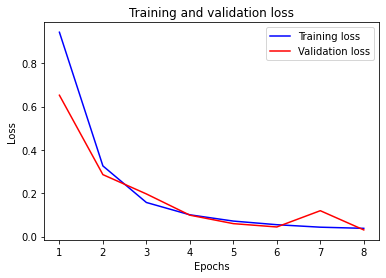

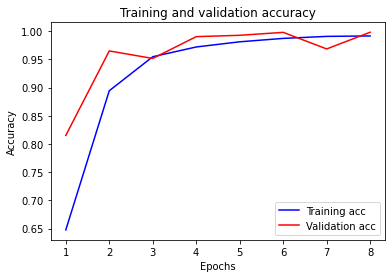

3752/3752 [==============================] - 0s 122us/step
test_acc: 0.9986673593521118
orginal data test_acc: 0.9986673773987207


In [29]:
#begin training and get loss
history = model.fit(train_data, train_label, epochs=8, batch_size=128, validation_split=0.3)
model.save('fiber.h5') #save training results

loss = history.history['loss']
val_loss = history.history['val_loss']
#print('val loss', val_loss)
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#accuracy of training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#print('val acc', val_acc)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_label)
print('test_acc:', test_acc)
pred_score = model.predict(test_data)
sigpre = pred_score.argmax(1)
sigtst = test_label.argmax(1)
d=(sigpre==sigtst)
dt=sum(d==True)
per=dt/test_data.shape[0]
print('orginal data test_acc:', per) #precent result of right predicted


# test trained model

In [30]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('test_acc:', test_acc)
pred_score = model.predict(test_data)
sigpre = pred_score.argmax(1)
sigtst = test_label.argmax(1)
d=(sigpre==sigtst)
dt=sum(d==True)
per=dt/test_data.shape[0]
print('test_acc:', per) #precent result of right predicted

3752/3752 [==============================] - 0s 121us/step
test_acc: 0.9986673593521118
test_acc: 0.9986673773987207
